In [1]:

import numpy as np
import pydicom
import os
import sys
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

print(tf.__version__)
print(keras.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')
import cv2


2.8.1
2.8.0
Num GPUs Available:  0


2022-12-08 14:59:03.396138: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-08 14:59:03.396249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mim-1-3
2022-12-08 14:59:03.396278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mim-1-3
2022-12-08 14:59:03.396579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-12-08 14:59:03.396646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-12-08 14:59:03.396674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5


In [146]:
np.mean(scan[scan.pe_present_on_image == True].preds.to_list())

0.7903021098687671

In [133]:
exam[exam.pe_present_on_image == True].check.mean()

0.5015964958025143

In [127]:
(subset[subset.pe_present_on_image == True].check > 0.5).mean()

0.38783269961977185

In [2]:
.Stall_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)
    all_ids_slab['pe_in_slab'] = all_ids_slab['pe_in_slab'] + all_ids_slab['pe_' + str(i)]

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)

/tmp/ipykernel_1772821/1481971415.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [34]:
for fold in range(0,10):
    DIR = '/home/shared/nps/coat_np_0'+str(fold) + '/'

    all_preds = np.zeros((len(all_ids_slab), 1))
    index = 0
    for i in range(len(all_ids_slab.StudyInstanceUID.unique())):
        study_id = all_ids_slab.StudyInstanceUID.unique()[i]
        scan = pd.DataFrame(np.load(DIR +study_id + '.npy', allow_pickle=True).tolist())
        all_preds[index:index+len(scan)] = scan.preds.tolist()
        index = index + len(scan)
        if i % 100 == 0:
            print(i)
    all_ids_slab['pred_0' + str(fold)] = all_preds

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0

In [40]:
for fold in range(0,10):
    DIR = '/home/shared/nps/turku_0'+str(fold) + '/'

    all_preds = np.zeros((len(all_ids), 1))
    index = 0
    for i in range(len(all_ids.StudyInstanceUID.unique())):
        study_id = all_ids.StudyInstanceUID.unique()[i]
        scan = pd.DataFrame(np.load(DIR +study_id + '.npy', allow_pickle=True).tolist())
        all_preds[index:index+len(scan)] = scan.preds.tolist()
        index = index + len(scan)
        if i % 100 == 0:
            print(i)
    all_ids['turku_0' + str(fold)] = all_preds

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
0

In [149]:
all_ids[(all_ids.StudyInstanceUID == 'b11a626b05e3') & (all_ids.pe_present_on_image == True)].turku_00.mean()

0.1933889265398228

In [35]:
all_ids_slab.to_csv('/home/shared/nps/results_0to10.csv')

In [41]:
all_ids.to_csv('/home/shared/nps/turku_0to10.csv')

In [161]:
all_ids_slab.pe_in_slab.mean()

0.08082784679971669

In [159]:
cm[0].sum()/cm[1].sum(), cm

(11.431938840518157,
 array([[97951,  9715],
        [ 2391,  7027]]))

In [154]:
do = pd.DataFrame(columns=['fold','auc','sensitivity','specificity','npv','ppv','accuracy'])
from sklearn.metrics import confusion_matrix
from sklearn import metrics
for fold in range(0,10):
    all_ids_fold = all_ids_slab[all_ids_slab.fold == fold]
    y_pred = all_ids_fold['pred_0'+str(fold)]
    y_test = all_ids_fold.pe_in_slab

    cm = confusion_matrix(y_test, y_pred.round())

    sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    specificity= cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    npv = cm[0][0]/(cm[0][0]+cm[1][0])
    ppv = cm[1][1]/(cm[1][1]+cm[0][1])

    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
    
    print(sensitivity, specificity, (sensitivity+specificity)/2, roc_auc)

/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)


0.8395981087470449 0.8889566132875271 0.864277361017286 0.9391098801295611
0.8214249518597345 0.8870091915662539 0.8542170717129942 0.9290970758332501
0.8571711961912319 0.8298861022482749 0.8435286492197533 0.9209713827728601


/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipyke

0.8210278875948285 0.8673831254162842 0.8442055065055563 0.9273878757555929
0.8425876010781671 0.8740464152359173 0.8583170081570421 0.9339612798488759
0.8371339145987033 0.8928415419897346 0.864987728294219 0.9397999219679931
0.7916896285682795 0.9014899048503133 0.8465897667092964 0.9213244671255101
0.7876982388504337 0.8844106322080199 0.8360544355292268 0.9130395427430733
0.8723231503095504 0.8243521790341578 0.8483376646718541 0.9343555222571267
0.7461244425568061 0.9097672431408244 0.8279458428488152 0.9112268292876221


/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
/tmp/ipykernel_1772821/3267201499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  do = do.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)


In [46]:
all_ids = pd.merge(all_ids, fold_df)

In [155]:
do.mean()

fold           4.500000
auc            0.927027
sensitivity    0.821678
specificity    0.876014
npv            0.982418
ppv            0.373201
accuracy       0.871622
dtype: float64

In [75]:
dt = pd.DataFrame(columns=['fold','auc','sensitivity','specificity','npv','ppv','accuracy'])
from sklearn.metrics import confusion_matrix
from sklearn import metrics
for fold in range(0,10):
    all_ids_fold = all_ids[all_ids.fold == fold]
    y_pred = all_ids_fold['turku_0'+str(fold)]
    y_test = all_ids_fold.pe_present_on_image

    cm = confusion_matrix(y_test, y_pred.round())

    sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    npv = cm[0][0]/(cm[0][0]+cm[1][0])
    ppv = cm[1][1]/(cm[1][1]+cm[0][1])

    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
                    'sensitivity':sensitivity,'specificity':specificity,'npv':npv,'ppv':ppv},ignore_index=True)
    
    print(sensitivity, specificity, (sensitivity+specificity)/2, roc_auc)

/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,


0.15364614111807115 0.8492562224674626 0.5014511817927668 0.49630379530585633
0.1542903454563874 0.8461762590255584 0.5002333022409728 0.5064283489581363
0.2122384211048299 0.7932623171547121 0.502750369129771 0.5024076518887209
0.14604700854700856 0.8564416741506096 0.501244341348809 0.5010337834946818


/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,


0.18756063382559016 0.8115280744179478 0.499544354121769 0.49708160454879635
0.19224321001453 0.807133932022689 0.49968857101860953 0.498542300871184
0.19903019616486664 0.8015199295955411 0.5002750628802038 0.49840530106690756
0.2042407780601069 0.7966654084460362 0.5004530932530715 0.5014064266320031
0.15932616196468438 0.8420626914233261 0.5006944266940052 0.5031065331428812
0.18590083873022614 0.8237101582205916 0.5048054984754089 0.5028603763551106


/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,
/tmp/ipykernel_1772821/1829507533.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append({'fold':fold,'auc':roc_auc,'accuracy':accuracy,


In [61]:
from scipy.stats import ranksums
for col in do.columns:
    print(col)
    print(ranksums(dt[col], do[col]))

fold
RanksumsResult(statistic=0.0, pvalue=1.0)
auc
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
sensitivity
RanksumsResult(statistic=-3.1749015732775088, pvalue=0.001498873337151676)
specificity
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
npv
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
ppv
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
accuracy
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)


In [62]:
dt

,fold,auc,sensitivity,specificity,npv,ppv,accuracy
0,0.0,0.496304,0.849256,0.153646,0.072919,0.928587,0.799423
1,1.0,0.506428,0.846176,0.15429,0.082695,0.917576,0.789119
2,2.0,0.502408,0.793262,0.212238,0.086601,0.915991,0.744139
3,3.0,0.501034,0.856442,0.146047,0.078061,0.923373,0.80186
4,4.0,0.497082,0.811528,0.187561,0.075341,0.924242,0.764307
5,5.0,0.498542,0.807134,0.192243,0.074218,0.925506,0.761361
6,6.0,0.498405,0.80152,0.19903,0.076992,0.923253,0.755251
7,7.0,0.501406,0.796665,0.204241,0.095466,0.905015,0.740336
8,8.0,0.503107,0.842063,0.159326,0.082858,0.917929,0.785945
9,9.0,0.50286,0.82371,0.185901,0.083496,0.921332,0.77299


In [39]:
do.auc.mean()

0.9270273777721465

In [37]:
thres = 0.5
pred_0_vals = all_ids_slab[all_ids_slab.pred_00 > thres].StudyInstanceUID.value_counts()
pred_1_vals = all_ids_slab[all_ids_slab.pred_01 > thres].StudyInstanceUID.value_counts()
pred_2_vals = all_ids_slab[all_ids_slab.pred_02 > thres].StudyInstanceUID.value_counts()
pred_3_vals = all_ids_slab[all_ids_slab.pred_03 > thres].StudyInstanceUID.value_counts()
pred_4_vals = all_ids_slab[all_ids_slab.pred_04 > thres].StudyInstanceUID.value_counts()
pe_vals = all_ids_slab[all_ids_slab.pe_in_slab > 0.5].StudyInstanceUID.value_counts()
scan_len = all_ids_slab.StudyInstanceUID.value_counts()

In [20]:
def get_count(x, val_col, scan_type):
    if x.StudyInstanceUID in val_col:
        return val_col[x.StudyInstanceUID]
    if scan_type == 0 and x.negative_exam_for_pe == True:
        return 0
    if scan_type == 1 and x.negative_exam_for_pe == False:
        return 0
    return ' '

for fold in range(0,5):
    all_ids_fold = all_ids_slab[all_ids_slab.fold == fold]
    fold_pos_pos = all_ids_fold[(all_ids_fold.negative_exam_for_pe == False) & (all_ids_fold.pe_in_slab == True)]
    fold_pos_neg = all_ids_fold[(all_ids_fold.negative_exam_for_pe == False) & (all_ids_fold.pe_in_slab == False)]
    fold_neg = all_ids_fold[all_ids_fold.negative_exam_for_pe == True]
    pe_count = all_ids_fold[all_ids_fold.pe_in_slab == True].StudyInstanceUID.value_counts()
    pred_pos_false_pos = fold_pos_neg[fold_pos_neg['pred_0'+str(fold)] >= 0.5].StudyInstanceUID.value_counts()
    pred_pos_false_neg = fold_pos_pos[fold_pos_pos['pred_0'+str(fold)] < 0.5].StudyInstanceUID.value_counts()
    pred_neg_false_pos = fold_neg[fold_neg['pred_0'+str(fold)] >= 0.5].StudyInstanceUID.value_counts()
    scan_len = all_ids_fold.StudyInstanceUID.value_counts()
    
    fold_scan = all_ids_fold.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'qa_motion','qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe','rightsided_pe', 
        'acute_and_chronic_pe', 'central_pe', 'indeterminate', 'ycoord', 'contains_lung', 
        'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1', 'pe_2', 'SOP_2', 'pred_02',
        'pred_03', 'pred_04', 'pred_00', 'pred_01','fold', 'pe_present_on_image'])
    fold_scan = fold_scan.drop_duplicates('StudyInstanceUID').reset_index(drop=True)
    
    fold_scan['pos_false_pos'] = fold_scan.apply(lambda x: get_count(x, pred_pos_false_pos, 1), axis=1)
    fold_scan['neg_false_pos'] = fold_scan.apply(lambda x: get_count(x, pred_neg_false_pos, 0), axis=1)
    fold_scan['pos_false_neg'] = fold_scan.apply(lambda x: get_count(x, pred_pos_false_neg, 1), axis=1)
    fold_scan['scan_len'] = fold_scan.apply(lambda x: get_count(x, scan_len, -1), axis=1)
    fold_scan['num_pe'] = fold_scan.apply(lambda x: get_count(x, pe_count, 0), axis=1)
    fold_scan.to_csv('false_pos_neg_fold_0'+ str(fold)+'.csv')
    

In [24]:
all_ids_scans = all_ids_slab.drop_duplicates('StudyInstanceUID')
all_ids_scans = all_ids_scans.drop(columns = ['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image','ycoord', 'contains_lung', 'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1',
       'pe_2', 'SOP_2', 'pred_02', 'pred_03', 'pred_04', 'pred_01', 'pred_00'])
all_ids_scans = all_ids_scans.sort_values('StudyInstanceUID').reset_index(drop=True)

In [38]:
def get_count(x, val_col):
    if x.StudyInstanceUID in val_col:
        return val_col[x.StudyInstanceUID]
    else:
        return 0

In [39]:
all_ids_scans['pred_02'] = all_ids_scans.apply(lambda x: get_count(x, pred_2_vals), axis=1)
all_ids_scans['pred_03'] = all_ids_scans.apply(lambda x: get_count(x, pred_3_vals), axis=1)
all_ids_scans['pred_04'] = all_ids_scans.apply(lambda x: get_count(x, pred_4_vals), axis=1)
all_ids_scans['pred_00'] = all_ids_scans.apply(lambda x: get_count(x, pred_0_vals), axis=1)
all_ids_scans['pred_01'] = all_ids_scans.apply(lambda x: get_count(x, pred_1_vals), axis=1)
all_ids_scans['pe_count'] = all_ids_scans.apply(lambda x: get_count(x, pe_vals), axis=1)
all_ids_scans['scan_len'] = all_ids_scans.apply(lambda x: get_count(x, scan_len), axis=1)

In [40]:
all_ids_neg = all_ids_scans[all_ids_scans.negative_exam_for_pe == True]
all_ids_pos = all_ids_scans[all_ids_scans.negative_exam_for_pe == False]

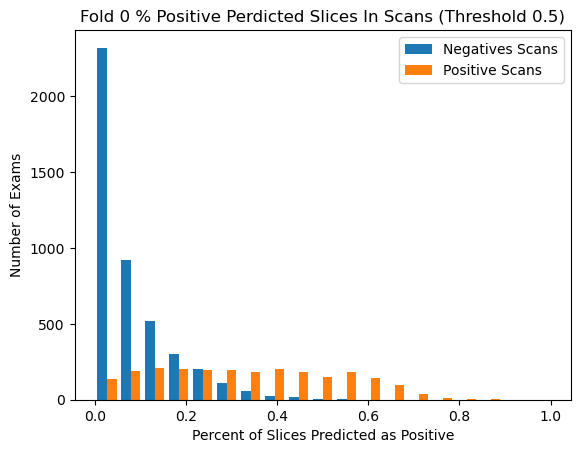

In [48]:
import matplotlib.pyplot as plt

fold = 0
bins = np.linspace(0,1,20)
neg_x = all_ids_neg['pred_0'+str(fold)]/all_ids_neg.scan_len
pos_y = all_ids_pos['pred_0'+str(fold)]/all_ids_pos.scan_len
plt.hist([neg_x, pos_y], bins, label=['Negatives Scans', 'Positive Scans'])
plt.legend()
plt.xlabel('Percent of Slices Predicted as Positive')
plt.ylabel('Number of Exams')
plt.title('Fold ' + str(fold)+' % Positive Perdicted Slices In Scans (Threshold '+str(thres)+')')
plt.show()

In [55]:
split = 0.12
print(len(neg_x[neg_x < split])/len(neg_x))
print(len(pos_y[pos_y >= split])/len(pos_y))

0.7568049977688532
0.8346965131295738


In [37]:
fold_df = pd.read_csv('folds.csv')
all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_scans = pd.merge(all_ids_scans, fold_df)

In [42]:
fold = 6
all_id_fold_neg= all_ids_scans[(all_ids_scans.fold == fold) & (all_ids_scans.negative_exam_for_pe == True)]
print((all_id_fold_neg['pred_0'+str(fold)]/all_id_fold_neg.scan_len).mean())

all_id_fold_pos= all_ids_scans[(all_ids_scans.fold == fold) & (all_ids_scans.negative_exam_for_pe == False)]
print((all_id_fold_pos['pred_0'+str(fold)]/all_id_fold_pos.scan_len).mean())

0.11377241793505523
0.2872931588757168


In [53]:
fold = 2
all_id_fold_pos = all_ids_slab[(all_ids_slab.fold == fold) & (all_ids_slab.negative_exam_for_pe == False)]
(all_id_fold_pos[all_id_fold_pos.pe_present_on_image == True]['pred_0' + str(fold)] > 0.5).mean()

0.741765873015873

In [188]:
test_03 = all_ids_scans[all_ids_scans.fold == 3]
test_03['exam_pred'] = test_03.pred_03/test_03.scan_len < split

/tmp/ipykernel_254696/3719095165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_03['exam_pred'] = test_03.pred_03/test_03.scan_len < split


In [193]:
print(len(test_03[(test_03.negative_exam_for_pe == False) & (test_03.exam_pred == False)])/len(test_03[(test_03.negative_exam_for_pe == False)]))
print(len(test_03[(test_03.negative_exam_for_pe == True) & (test_03.exam_pred == True)])/len(test_03[(test_03.negative_exam_for_pe == True)]))

0.7739130434782608
0.7694013303769401


In [126]:
split = 0.00924
len(all_ids_pos[all_ids_pos.pred_03/all_ids_pos.scan_len >= split]) / len(all_ids_pos)

0.709427464485579

In [127]:
len(all_ids_neg[all_ids_neg.pred_03/all_ids_neg.scan_len < split]) / len(all_ids_neg)

0.8904506916555109

In [124]:
(all_ids_pos.pred_03/all_ids_pos.scan_len).median(), (all_ids_neg.pred_03/all_ids_neg.scan_len).median()

(0.054187192118226604, 0.0)

In [128]:
 0.5*((all_ids_pos.pred_03/all_ids_pos.scan_len).median()*len(all_ids_pos)+  len(all_ids_neg)*(all_ids_neg.pred_03/all_ids_neg.scan_len).median())/(len(all_ids_pos)+len(all_ids_neg))

0.021165103735471362

In [178]:
slice_thresholds = np.arange(0.7,0.92,0.02)
best_thres = np.zeros((5))
best_split = np.zeros((5))
best_scores = np.zeros((5,3))

for fold in range(2,7):
    for j in range(len(slice_thresholds)):
        thres = slice_thresholds[j]
        
        pred_vals = all_ids_slab[all_ids_slab['pred_0'+str(fold)] > thres].StudyInstanceUID.value_counts()
        all_ids_scans['pred_opt'] = all_ids_scans.apply(lambda x: get_count(x, pred_vals), axis=1)
        all_ids_neg_train = all_ids_scans[(all_ids_scans.negative_exam_for_pe == True) & (all_ids_scans.fold != fold)]
        all_ids_pos_train = all_ids_scans[(all_ids_scans.negative_exam_for_pe == False) & (all_ids_scans.fold != fold)]

        all_ids_neg_test = all_ids_scans[(all_ids_scans.negative_exam_for_pe == True) & (all_ids_scans.fold == fold)]
        all_ids_pos_test = all_ids_scans[(all_ids_scans.negative_exam_for_pe == False) & (all_ids_scans.fold == fold)]

        split = 0.5*(len(all_ids_pos_train)*(all_ids_pos_train.pred_opt/all_ids_pos_train.scan_len).mean() + len(all_ids_neg_train)*((all_ids_neg_train.pred_opt/all_ids_neg_train.scan_len).mean()))/(len(all_ids_neg_train) + len(all_ids_pos_train))
        step = 0.005
        score = 0
        for i in range(1000): 
            split = split + score * step
            pos_score = len(all_ids_pos_train[all_ids_pos_train.pred_opt/all_ids_pos_train.scan_len >= split]) / len(all_ids_pos_train)
            neg_score = len(all_ids_neg_train[all_ids_neg_train.pred_opt/all_ids_neg_train.scan_len < split]) / len(all_ids_neg_train)
            score = pos_score - neg_score
            if abs(score) < 0.005:
                break
            
        specificity = len(all_ids_neg_test[all_ids_neg_test.pred_opt/all_ids_neg_test.scan_len < split]) / len(all_ids_neg_test)
        sensitivity = len(all_ids_pos_test[all_ids_pos_test.pred_opt/all_ids_pos_test.scan_len >= split]) / len(all_ids_pos_test)
        accuracy = (specificity * len(all_ids_neg_test) + sensitivity * len(all_ids_pos_test))/(len(all_ids_pos_test)+len(all_ids_neg_test))
        if specificity + sensitivity > best_scores[fold -2][0] + best_scores[fold -2][1]:
            best_scores[fold -2][0]= specificity
            best_scores[fold -2][1]= sensitivity
            best_scores[fold -2][2]= accuracy
            best_thres[fold -2] = thres
            best_split[fold -2] = split
                     

In [179]:
i, pos_score, neg_score, best_scores, best_thres, best_split

(24,
 0.7895238095238095,
 0.7930434782608695,
 array([[0.75675676, 0.7721519 , 0.76211454],
        [0.78935698, 0.77826087, 0.7856094 ],
        [0.75646552, 0.78801843, 0.76651982],
        [0.81637168, 0.8377193 , 0.82352941],
        [0.7833698 , 0.74887892, 0.77205882]]),
 array([0.88, 0.84, 0.92, 0.84, 0.88]),
 array([0.01166699, 0.02238759, 0.00622738, 0.02297954, 0.01092769]))

In [181]:
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence

num_features = 64
MAX_SEQ_LENGTH = 200

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, num_features, directory, fold,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, full_set = None, random=False, set_type='test'):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.fold = fold
        self.num_features = num_features
        self.seq_length = seq_length
        self.full_set = full_set
        self.return_type = return_type
        self.random = random
        warnings.filterwarnings(action='ignore')
        self.directory = directory
        self.set_type = set_type
        
        if self.set_type == 'val':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
            self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        
        self.on_epoch_end()
            
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            X[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
#         X = X.squeeze()
            
        if self.to_fit:
            if self.return_type =='both':
                return (X, [np.array(y_seq), y_tot])
            elif self.return_type == 'seq':
                return (X, y_seq)
            elif self.return_type == 'tot':
                return (X, y_tot)
            else:
                print('valid return types are both, seq and tot')
                return False
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
#             self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac=1).reset_index(drop=True)
            self.study_ids = pd.concat([sample_pos.sample(n=len(sample_neg), replace=True), sample_neg]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = pd.DataFrame(np.load(self.directory +study_id + '.npy', allow_pickle=True).tolist())
        scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
        scan = scan.sort_values(by=['ycoord'], ascending=False).reset_index(drop=True)
        
        features = scan.preds.tolist()
        seq = scan.pe_present_on_image.tolist()
        seq = np.reshape(seq, [len(seq),1])
        tot = self.study_ids[self.study_ids.StudyInstanceUID == study_id].negative_exam_for_pe.iloc[0]
        
#         if self.set_type == 'train':
#             new_len = int(len(scan) * (random.random()*0.2 +0.9))
#             inst = np.round(np.arange(0,new_len)/new_len*len(features)).astype(int)
#             features = (np.array(features)[inst]).tolist()
#             seq = seq[inst]            
            
        features = np.reshape(features, [len(features), 1])
        if len(features)>=self.seq_length:
            inst = np.round(np.arange(0,self.seq_length)/self.seq_length*len(features)).astype(int)
            xs = (np.array(features)[inst]).tolist()
            ys = seq[inst]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])
            
            xs[:len(features)] = features
            ys[:len(features)] = seq
        
        ys = ys.tolist()
        
        return (xs, [ys, tot])

def get_generators(df, fold, batch_size, out):
    test_df = df[df.fold == fold]
    train_df = df[df.fold != fold]
    
    print(train_df.fold.unique())
    print(test_df.fold.unique())
    
    dire = '/home/shared/nps/coat_np_0' + str(fold) + '/'

    test_generator = DataGenerator(np.arange(0, len(test_df)),
                                    test_df, 
                                    1,
                                    dire,
                                    fold,
                                    MAX_SEQ_LENGTH,
                                    batch_size=batch_size,
                                    set_type = 'test',
                                    return_type=out)
    
    val_generator = DataGenerator(np.arange(0, len(test_df)),
                                  test_df, 
                                  1,
                                  dire,
                                  fold,
                                  MAX_SEQ_LENGTH,
                                  batch_size=batch_size,
                                  set_type ='val',
                                  full_set=test_df,
                                  return_type=out)
    
    train_generator = DataGenerator(np.arange(0, len(train_df)),
                                  train_df, 
                                  1,
                                  dire,
                                  fold,
                                  MAX_SEQ_LENGTH,
                                  batch_size=batch_size,
                                  set_type ='train',
                                  full_set = train_df,
                                  random = True,
                                  return_type=out)
    
    return train_generator, val_generator, test_generator

In [238]:
all_ids_slab.to_csv('/home/shared/nps/results_fold2to6.csv')

In [182]:
from tensorflow.keras import layers

def get_conv_model(seq_len=200, dim=1):
    inputs = keras.Input(shape=(seq_len,1))
#     x = layers.Dense(64, activation='relu')(inputs)
#     x = layers.Dense(32, activation='relu')(x)
#     x = layers.Dense(8, activation='relu')(x)
#     x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(filters=16, kernel_size=18, activation='relu')(inputs)
#     x = layers.Conv1D(filters=16, kernel_size=8, activation='relu')(x)
    x = layers.TimeDistributed(layers.Dropout(0.4))(x)
#     x = layers.Conv1D(filters=8, kernel_size=4, activation='relu')(x)
    x = layers.Conv1D(filters=8,kernel_size=8, activation='relu')(x)
    x = layers.TimeDistributed(layers.Dropout(0.4))(x)
#     x = layers.Conv1D(filters=8, kernel_size=4, activation='relu')(x)
    x = layers.Conv1D(filters=4,kernel_size=4, activation='relu')(x)
    x = layers.Flatten()(x)  
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)                                         
    stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)
    model = keras.models.Model(inputs=inputs, outputs=stack_outputs)
        
    return model

In [183]:
fold = 4
training_generator, validation_generator, test_generator = get_generators(all_ids_scans, fold, 16, 'tot')

[7 8 0 9 2 5 1 6 3]
[4]


In [184]:
model = get_conv_model()
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
model.summary()

model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
#     batch_size=1,
    shuffle=True,
)

# model.evaluate(x_test, y_test, verbose=1)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 183, 16)           304       
                                                                 
 time_distributed (TimeDistr  (None, 183, 16)          0         
 ibuted)                                                         
                                                                 
 conv1d_1 (Conv1D)           (None, 176, 8)            1032      
                                                                 
 time_distributed_1 (TimeDis  (None, 176, 8)           0         
 tributed)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 173, 4)            132   

2022-11-17 13:06:15.755389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 13:06:16.918077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11470 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:06:00.0, compute capability: 5.2


Epoch 1/10


2022-11-17 13:06:19.944197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-17 13:06:20.936317: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


502/502 [==============================] - 96s 184ms/step - loss: 0.5342 - accuracy: 0.7130 - val_loss: 0.4670 - val_accuracy: 0.7940
Epoch 2/10
502/502 [==============================] - 87s 173ms/step - loss: 0.4656 - accuracy: 0.7804 - val_loss: 0.4627 - val_accuracy: 0.7963
Epoch 3/10
502/502 [==============================] - 89s 178ms/step - loss: 0.4540 - accuracy: 0.7878 - val_loss: 0.4395 - val_accuracy: 0.7917
Epoch 4/10
502/502 [==============================] - 89s 177ms/step - loss: 0.4467 - accuracy: 0.7880 - val_loss: 0.4473 - val_accuracy: 0.8032
Epoch 5/10
502/502 [==============================] - 89s 177ms/step - loss: 0.4510 - accuracy: 0.7837 - val_loss: 0.5668 - val_accuracy: 0.6898
Epoch 6/10
502/502 [==============================] - 87s 173ms/step - loss: 0.4468 - accuracy: 0.7922 - val_loss: 0.5302 - val_accuracy: 0.7338
Epoch 7/10
502/502 [==============================] - 87s 174ms/step - loss: 0.4436 - accuracy: 0.7907 - val_loss: 0.5461 - val_accuracy: 0.7

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_version(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred.round())

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
    print(cm)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()
    # plt.show()

In [106]:
all_pred_flat =[]
for i in range(len(all_preds)):
    for j in range(len(all_preds[i])):
        all_pred_flat.append(all_preds[i][j])


In [107]:
all_ids_slab['pred'] = np.asarray(all_pred_flat).flatten()

In [115]:
test_neg = all_ids_test[all_ids_test.negative_exam_for_pe == True]
len(test_neg[test_neg.pred > 0.5]), len(test_neg)

(6617, 58486)

In [121]:
test_pos = all_ids_test[all_ids_test.negative_exam_for_pe == False]
test_pos = test_pos[test_pos.pe_present_on_image == False]
len(test_pos[test_pos.pred > 0.5]), len(test_pos)

(3443, 22472)

In [124]:
6617/58486*100, 8653/29493*100, 3443/22472*100

(11.313818691652704, 29.339165225646763, 15.32128871484514)

4
 0.8753865918066327 
 0.7738195026543727 
 0.9784738934464373 
 0.3458632532001249 
 0.8674171836976301
[[73592 10476]
 [ 1619  5539]]


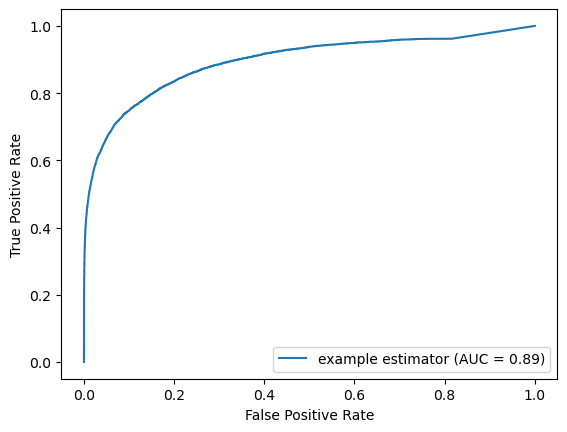

In [93]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

5
 0.8699035717428747 
 0.7930331084261729 
 0.9812939641479465 
 0.32813920270094793 
 0.8642014107130386
[[69193 10348]
 [ 1319  5054]]


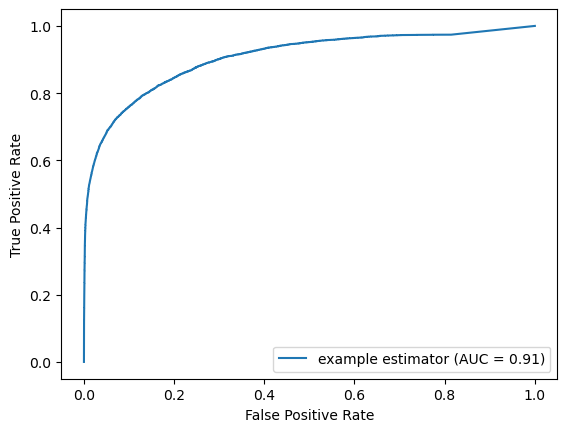

In [100]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

6
 0.8757889796069616 
 0.7427350427350428 
 0.9751612592663906 
 0.34145383104125737 
 0.8651723706793667
[[70903 10056]
 [ 1806  5214]]


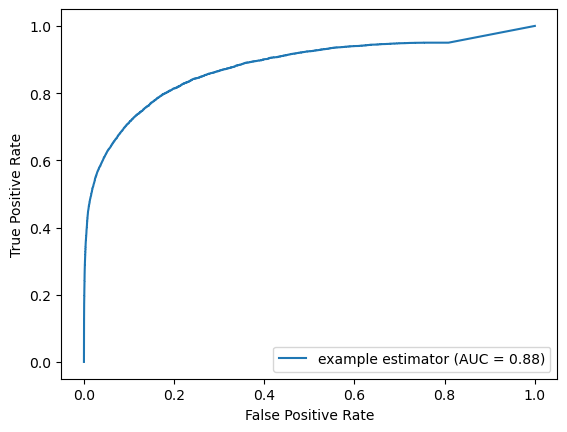

In [109]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

In [2]:
all_ids_slab = pd.read_csv('/home/shared/nps/results_fold2to6.csv')

In [3]:
all_ids_slab.ycoord = all_ids_slab.ycoord.replace('True', '1.0').astype('float')
all_ids_slab = all_ids_slab.sort_values(by=['StudyInstanceUID', 'ycoord']).reset_index(drop=True)

In [63]:
all_ids_scan = all_ids_slab.drop_duplicates('StudyInstanceUID')
all_ids_scan = all_ids_scan.drop(columns=['Unnamed: 0', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'ycoord', 'contains_lung', 'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1',
       'pe_2', 'SOP_2', 'pred_02', 'pred_03', 'pred_04', 'pred_05', 'pred_06']).reset_index(drop=True)

fold_df = pd.read_csv('folds.csv')
all_ids_scan = pd.merge(all_ids_scan, fold_df)
all_ids_slab = pd.merge(all_ids_slab, fold_df)

In [260]:
fold =5
for i in range(-2, 3):
    if i != 0:
        all_ids_slab['sm_m'+ str(i)+'_05'] = all_ids_slab['pred_0'+str(fold)].shift(i)
    if abs(i) == 2:
        all_ids_slab['sm_m_id'+str(i)] = all_ids_slab.StudyInstanceUID.shift(i)

In [262]:
all_ids_slab

,Unnamed: 0,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,...,pred_05,pred_06,fold,sm_m-2_05,sm_m_id,sm_m-1_05,sm_m1_05,sm_m2_05,sm_m_id-2,sm_m_id2
0,0,0003b3d648eb,d2b2960c2bbf,a5561e6954f4,0,1,0,0,0,0,...,0.000230,0.000623,7,0.000244,NaN,0.000185,NaN,NaN,0003b3d648eb,NaN
1,1,0003b3d648eb,d2b2960c2bbf,382770a065f4,0,1,0,0,0,0,...,0.000185,0.002213,7,0.000024,NaN,0.000244,0.000230,NaN,0003b3d648eb,NaN
2,2,0003b3d648eb,d2b2960c2bbf,571418732f35,0,1,0,0,0,0,...,0.000244,0.000850,7,0.000074,0003b3d648eb,0.000024,0.000185,0.000230,0003b3d648eb,0003b3d648eb
3,3,0003b3d648eb,d2b2960c2bbf,4916256ab8f6,0,1,0,0,0,0,...,0.000024,0.000796,7,0.000073,0003b3d648eb,0.000074,0.000244,0.000185,0003b3d648eb,0003b3d648eb
4,4,0003b3d648eb,d2b2960c2bbf,506413a4652c,0,1,0,0,0,0,...,0.000074,0.000799,7,0.000350,0003b3d648eb,0.000073,0.000024,0.000244,0003b3d648eb,0003b3d648eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184562,1184562,fffda3f22362,39ca5eaafffe,63bcdac30827,0,1,0,0,0,0,...,0.000000,0.000000,4,0.000000,fffda3f22362,0.000000,0.000000,0.000000,fffda3f22362,fffda3f22362
1184563,1184563,fffda3f22362,39ca5eaafffe,3518d425e229,0,1,0,0,0,0,...,0.000000,0.000000,4,0.000000,fffda3f22362,0.000000,0.000000,0.000000,fffda3f22362,fffda3f22362
1184564,1184564,fffda3f22362,39ca5eaafffe,776810a1d086,0,1,0,0,0,0,...,0.000000,0.000000,4,0.000000,fffda3f22362,0.000000,0.000000,0.000000,fffda3f22362,fffda3f22362
1184565,1184565,fffda3f22362,39ca5eaafffe,d619df48a08d,0,1,0,0,0,0,...,0.000000,0.000000,4,NaN,fffda3f22362,0.000000,0.000000,0.000000,NaN,fffda3f22362


In [266]:
all_ids_slab_shift = all_ids_slab[(all_ids_slab.StudyInstanceUID == all_ids_slab['sm_m_id-2']) & (all_ids_slab.StudyInstanceUID == all_ids_slab['sm_m_id2'])]
all_ids_slab_shift = all_ids_slab_shift.drop(columns=['sm_m_id', 'sm_m_id-2','sm_m_id2'])

In [292]:
all_ids_slab_shift['smoothed'] = all_ids_slab_shift.pred_05 + all_ids_slab_shift.sm_m1_05 + all_ids_slab_shift['sm_m-1_05']

In [26]:
def get_count(x, val_col):
    if x.StudyInstanceUID in val_col:
        return val_col[x.StudyInstanceUID]

    return 0

In [203]:
def get_max_seq_len(x, df, thres, fold):
    a = (df.loc[df.StudyInstanceUID == x.StudyInstanceUID, 'pred_0'+str(fold)] > thres).values
    b = pd.factorize((~a).cumsum())[0]
    if len(b[a]) == 0:
        return 0
    return np.bincount(b[a]).max()

def get_max_score(x, df, fold):
    return df.loc[df.StudyInstanceUID == x.StudyInstanceUID,  'pred_0'+str(fold)].values.max()

fold = 5

pred_pe_05_50 = all_ids_slab[all_ids_slab['pred_0'+str(fold)] >=0.5].StudyInstanceUID.value_counts()
pred_pe_05_85 = all_ids_slab[all_ids_slab['pred_0'+str(fold)] >=0.85].StudyInstanceUID.value_counts()
pred_pe_05_90 = all_ids_slab[all_ids_slab['pred_0'+str(fold)] >=0.9].StudyInstanceUID.value_counts()
scan_len = all_ids_slab.StudyInstanceUID.value_counts()

all_ids_scan['pred_05_50'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_05_50), axis=1)
all_ids_scan['pred_05_85'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_05_85), axis=1)
all_ids_scan['pred_05_90'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_05_90), axis=1)
all_ids_scan['scan_len'] = all_ids_scan.apply(lambda x: get_count(x, scan_len), axis=1)
# all_ids_scan['max_seq_len_05_70'] = 0
# all_ids_scan['max_score_05'] = 0

# for i in range(0,10):
#     all_ids_scan_fold = all_ids_scan[all_ids_scan.fold ==i]
#     all_ids_slab_fold = all_ids_slab[all_ids_slab.fold ==i]
#     print(datetime.datetime.now())
#     all_ids_scan.loc[all_ids_scan.fold == i, 'max_seq_len_05_70'] = all_ids_scan_fold.apply(lambda x: get_max_seq_len(x, all_ids_slab_fold, 0.70, fold), axis=1)
# #     all_ids_scan.loc[all_ids_scan.fold == i, 'max_score_05'] = all_ids_scan_fold.apply(lambda x: get_max_score(x, all_ids_slab_fold, fold), axis=1)
#     print(datetime.datetime.now())

In [43]:
def get_count(x, val_col):
    if x.StudyInstanceUID in val_col:
        return val_col[x.StudyInstanceUID]

    return 0

def get_max_seq_len(x, df, thres, fold):
    a = (df.loc[df.StudyInstanceUID == x.StudyInstanceUID, 'smoothed'] > thres).values
    b = pd.factorize((~a).cumsum())[0]
    if len(b[a]) == 0:
        return 0
    return np.bincount(b[a]).max()

def get_max_score(x, df, fold):
    return df.loc[df.StudyInstanceUID == x.StudyInstanceUID,  'smoothed'].values.max()


In [307]:

fold = 5

# all_ids_scan_sm = all_ids_slab_shift.drop_duplicates('StudyInstanceUID')
# all_ids_scan_sm = all_ids_scan_sm.drop(columns=['Unnamed: 0', 'SeriesInstanceUID', 'SOPInstanceUID',
#        'pe_present_on_image', 'ycoord', 'contains_lung', 'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1',
#        'pe_2', 'SOP_2', 'pred_02', 'pred_03', 'pred_04', 'pred_05', 'pred_06','sm_m-2_05', 'sm_m-1_05', 'sm_m1_05', 'sm_m2_05', 'smoothed']).reset_index(drop=True)
# all_ids_slab_shift['smoothed'] = all_ids_slab_shift['smoothed']/3

# pred_pe_05_50 = all_ids_slab_shift[all_ids_slab_shift['smoothed'] >=0.5].StudyInstanceUID.value_counts()
# pred_pe_05_85 = all_ids_slab_shift[all_ids_slab_shift['smoothed'] >=0.85].StudyInstanceUID.value_counts()
# pred_pe_05_90 = all_ids_slab_shift[all_ids_slab_shift['smoothed'] >=0.9].StudyInstanceUID.value_counts()
# scan_len = all_ids_slab_shift.StudyInstanceUID.value_counts()

# all_ids_scan_sm['pred_05_50'] = all_ids_scan_sm.apply(lambda x: get_count(x, pred_pe_05_50), axis=1)
# all_ids_scan_sm['pred_05_85'] = all_ids_scan_sm.apply(lambda x: get_count(x, pred_pe_05_85), axis=1)
# all_ids_scan_sm['pred_05_90'] = all_ids_scan_sm.apply(lambda x: get_count(x, pred_pe_05_90), axis=1)
# all_ids_scan_sm['scan_len'] = all_ids_scan_sm.apply(lambda x: get_count(x, scan_len), axis=1)
all_ids_scan_sm['max_seq_len_05_85'] = 0
# all_ids_scan_sm['max_score_05'] = 0

for i in range(0,10):
    all_ids_scan_fold = all_ids_scan_sm[all_ids_scan_sm.fold ==i]
    all_ids_slab_fold = all_ids_slab_shift[all_ids_slab_shift.fold ==i]
#     print(datetime.datetime.now())
    all_ids_scan_sm.loc[all_ids_scan_sm.fold == i, 'max_seq_len_05_85'] = all_ids_scan_fold.apply(lambda x: get_max_seq_len(x, all_ids_slab_fold, 0.85, fold), axis=1)
#     all_ids_scan_sm.loc[all_ids_scan_sm.fold == i, 'max_score_05'] = all_ids_scan_fold.apply(lambda x: get_max_score(x, all_ids_slab_fold, fold), axis=1)
    print(datetime.datetime.now())

2022-11-18 16:11:37.828612
2022-11-18 16:11:55.043845
2022-11-18 16:12:12.867418
2022-11-18 16:12:30.578090
2022-11-18 16:12:48.658785
2022-11-18 16:13:07.434063
2022-11-18 16:13:24.968027
2022-11-18 16:13:41.865455
2022-11-18 16:13:58.998161
2022-11-18 16:14:15.874486


In [106]:
print(all_ids_scan[all_ids_scan.negative_exam_for_pe == False].max_seq_len_05_50.quantile(0.1))
print(all_ids_scan[all_ids_scan.negative_exam_for_pe == True].max_seq_len_05_50.quantile(0.8))

5.0
11.0


In [127]:
print(all_ids_scan[all_ids_scan.negative_exam_for_pe == False].pred_05_90.quantile(0.15))
print(all_ids_scan[all_ids_scan.negative_exam_for_pe == True].pred_05_90.quantile(0.7))

1.0
1.0


In [251]:
(all_scan_pos.max_score_05).quantile(0.4), (all_scan_neg.max_score_05).quantile(0.6)

(0.9898035407066346, 0.8931980967521668)

In [252]:
(all_scan_pos.max_seq_len_05_50).quantile(0.4), (all_scan_neg.max_seq_len_05_50).quantile(0.6)

(16.0, 6.0)

In [254]:
(all_scan_pos.pred_05_85/all_scan_pos.scan_len).quantile(0.4), (all_scan_neg.pred_05_85/all_scan_neg.scan_len).quantile(0.6)

(0.0681508967223253, 0.006944444444444444)

In [222]:
print((all_scan_pos.max_seq_len_05_50/all_scan_pos.scan_len).quantile(0.2))
print((all_scan_neg.max_seq_len_05_50/all_scan_neg.scan_len).quantile(0.8))

0.047619047619047616
0.06402222476801468


In [225]:
all_scan_pos = all_ids_scan[all_ids_scan.negative_exam_for_pe == False]
all_scan_neg = all_ids_scan[all_ids_scan.negative_exam_for_pe == True]

In [255]:
print(len(all_scan_pos[((all_scan_pos.pred_05_85/all_scan_pos.scan_len > 0.007) & (all_scan_pos.max_score_05 > 0.89) & (all_scan_pos.max_seq_len_05_50 > 6))])/len(all_scan_pos))
print(len(all_scan_neg[((all_scan_neg.pred_05_85/all_scan_neg.scan_len > 0.007) & (all_scan_neg.max_score_05 > 0.89) & (all_scan_neg.max_seq_len_05_50 > 6))== False])/len(all_scan_neg))


0.8028411536805854
0.7429718875502008


In [227]:
all_ids_scan.columns

Index(['StudyInstanceUID', 'negative_exam_for_pe', 'qa_motion', 'qa_contrast',
       'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',
       'fold', 'pred_05_50', 'pred_05_85', 'max_seq_len_05_50',
       'max_seq_len_05_85', 'max_score_05', 'max_seq_len_05_90', 'pred_05_90',
       'max_seq_len_05_70', 'scan_len'],
      dtype='object')

In [327]:
all_scan_pos_sm = all_ids_scan_sm[all_ids_scan_sm.negative_exam_for_pe == False]
all_scan_neg_sm = all_ids_scan_sm[all_ids_scan_sm.negative_exam_for_pe == True]

quant_pos = 0.4
qunat_neg = 0.6
print('Smoothed')
print((all_scan_pos_sm.max_score_05).quantile(quant_pos), (all_scan_neg_sm.max_score_05).quantile(qunat_neg))
# print((all_scan_pos_sm.max_seq_len_05_50).quantile(quant_pos), (all_scan_neg_sm.max_seq_len_05_50).quantile(qunat_neg))
print((all_scan_pos_sm.pred_05_85/all_scan_pos_sm.scan_len).quantile(quant_pos), (all_scan_neg_sm.pred_05_85/all_scan_neg_sm.scan_len).quantile(qunat_neg))
print((all_scan_pos_sm.max_seq_len_05_85/all_scan_pos_sm.scan_len).quantile(quant_pos), (all_scan_neg_sm.max_seq_len_05_85/all_scan_neg_sm.scan_len).quantile(qunat_neg))
print('\nOriginal')
print((all_scan_pos.max_score_05).quantile(quant_pos), (all_scan_neg.max_score_05).quantile(qunat_neg))
# print((all_scan_pos.max_seq_len_05_50).quantile(quant_pos), (all_scan_neg.max_seq_len_05_50).quantile(qunat_neg))
print((all_scan_pos.pred_05_85/all_scan_pos.scan_len).quantile(quant_pos), (all_scan_neg.pred_05_85/all_scan_neg.scan_len).quantile(qunat_neg))
print((all_scan_pos.max_seq_len_05_85/all_scan_pos.scan_len).quantile(quant_pos), (all_scan_neg.max_seq_len_05_85/all_scan_neg.scan_len).quantile(qunat_neg))



Smoothed
0.9709391156832377 0.779857623577118
0.049079754601226995 0.0
0.032679738562091505 0.0

Original
0.9898035407066346 0.8931980967521668
0.0681508967223253 0.006944444444444444
0.031446540880503145 0.006024096385542169


In [341]:
print(len(all_scan_pos_sm[((all_scan_pos_sm.max_score_05 > 0.86) & (all_scan_pos_sm.pred_05_85/all_scan_pos_sm.scan_len > 0) & (all_scan_pos_sm.max_seq_len_05_85/all_scan_pos_sm.scan_len > 0))])/len(all_scan_pos_sm))
print(len(all_scan_neg_sm[((all_scan_neg_sm.max_score_05 > 0.86) & (all_scan_neg_sm.pred_05_85/all_scan_neg_sm.scan_len > 0) & (all_scan_neg_sm.max_seq_len_05_85/all_scan_neg_sm.scan_len > 0))==False])/len(all_scan_neg_sm))

0.8015497201894103
0.7634984381972334


In [80]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)
    all_ids_slab['pe_in_slab'] = all_ids_slab['pe_in_slab'] + all_ids_slab['pe_' + str(i)]

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)

fold_df = pd.read_csv('folds.csv')
all_ids_slab = pd.merge(all_ids_slab, fold_df)

/tmp/ipykernel_604142/1205863845.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [82]:
all_ids_slab = all_ids_slab[all_ids_slab.fold ==0]
DIR = '/home/shared/nps/coat_np_00/'

all_preds = np.zeros((len(all_ids_slab), 1))
index = 0
for i in range(len(all_ids_slab.StudyInstanceUID.unique())):
    study_id = all_ids_slab.StudyInstanceUID.unique()[i]
    scan = pd.DataFrame(np.load(DIR +study_id + '.npy', allow_pickle=True).tolist())
    all_preds[index:index+len(scan)] = scan.preds.tolist()
    index = index + len(scan)
    if i % 100 == 0:
        print(i)
all_ids_slab['pred_00'] = all_preds

0
100
200
300
400
500
600


In [21]:
all_ids_slab_pos = all_ids_slab[all_ids_slab.pe_in_slab == True]
all_ids_slab_neg = all_ids_slab[all_ids_slab.pe_in_slab == False]

In [84]:
print((all_ids_slab_pos.pred_00 > 0.5).mean())
print((all_ids_slab_neg.pred_00 < 0.5).mean())

0.8013279748383715
0.8963512429831596


In [85]:
all_ids_scan = all_ids_slab.drop_duplicates('StudyInstanceUID')
all_ids_scan = all_ids_scan.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'ycoord', 'contains_lung', 'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1',
       'pe_2', 'SOP_2', 'pred_00']).reset_index(drop=True)

In [86]:
def get_count(x, val_col):
    if x.StudyInstanceUID in val_col:
        return val_col[x.StudyInstanceUID]

    return 0

def get_max_seq_len(x, df, thres):
    a = (df.loc[df.StudyInstanceUID == x.StudyInstanceUID, 'pred_00'] > thres).values
    b = pd.factorize((~a).cumsum())[0]
    if len(b[a]) == 0:
        return 0
    return np.bincount(b[a]).max()

def get_max_score(x, df):
    return df.loc[df.StudyInstanceUID == x.StudyInstanceUID,  'pred_00'].values.max()


In [140]:
pred_pe_00_50 = all_ids_slab[all_ids_slab['pred_00'] >= 0.50].StudyInstanceUID.value_counts()
pred_pe_00_75 = all_ids_slab[all_ids_slab['pred_00'] >= 0.75].StudyInstanceUID.value_counts()
pred_pe_00_85 = all_ids_slab[all_ids_slab['pred_00'] >= 0.85].StudyInstanceUID.value_counts()
pred_pe_00_90 = all_ids_slab[all_ids_slab['pred_00'] >= 0.90].StudyInstanceUID.value_counts()


all_ids_scan['pred_00_50'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_00_50), axis=1)
all_ids_scan['pred_00_75'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_00_75), axis=1)
all_ids_scan['pred_00_85'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_00_85), axis=1)
all_ids_scan['pred_00_90'] = all_ids_scan.apply(lambda x: get_count(x, pred_pe_00_90), axis=1)


all_ids_scan['max_seq_len_00_50'] = all_ids_scan.apply(lambda x: get_max_seq_len(x, all_ids_slab, 0.50), axis=1)
all_ids_scan['max_seq_len_00_75'] = all_ids_scan.apply(lambda x: get_max_seq_len(x, all_ids_slab, 0.75), axis=1)
all_ids_scan['max_seq_len_00_85'] = all_ids_scan.apply(lambda x: get_max_seq_len(x, all_ids_slab, 0.85), axis=1)
all_ids_scan['max_seq_len_00_90'] = all_ids_scan.apply(lambda x: get_max_seq_len(x, all_ids_slab, 0.90), axis=1)
all_ids_scan['max_score_00'] = all_ids_scan.apply(lambda x: get_max_score(x, all_ids_slab), axis=1)


In [169]:
all_ids_scan_pos = all_ids_scan[all_ids_scan.negative_exam_for_pe == False]
all_ids_scan_neg = all_ids_scan[all_ids_scan.negative_exam_for_pe == True]

In [159]:
all_ids_slab.ycoord = all_ids_slab.ycoord.replace('True', '1.0').astype('float')
all_ids_slab_sh = all_ids_slab.sort_values(by=['StudyInstanceUID','ycoord'])
fold =0
for i in range(-2, 3):
    if i != 0:
        all_ids_slab_sh['shift_'+str(i)] = all_ids_slab_sh['pred_00'].shift(i)
    if abs(i) == 2:
        all_ids_slab_sh['sm_m_id'+str(i)] = all_ids_slab_sh.StudyInstanceUID.shift(i)

In [160]:
all_ids_slab_sh = all_ids_slab_sh[all_ids_slab_sh['sm_m_id-2'] == all_ids_slab_sh.sm_m_id2].reset_index(drop=True)

In [161]:
all_ids_slab_sh['roll'] = all_ids_slab_sh.pred_00 + all_ids_slab_sh['shift_-2'] + all_ids_slab_sh['shift_-1'] + all_ids_slab_sh.shift_1 + all_ids_slab_sh.shift_2
all_ids_slab_sh['roll'] = all_ids_slab_sh.roll/5

In [162]:
all_ids_slab_sh = all_ids_slab_sh.drop(columns=['shift_-2','shift_-1','shift_1','shift_2','sm_m_id-2','sm_m_id2'])

In [168]:
def get_max_roll_len(x, df, thres):
    a = (df.loc[df.StudyInstanceUID == x.StudyInstanceUID, 'roll'] > thres).values
    b = pd.factorize((~a).cumsum())[0]
    if len(b[a]) == 0:
        return 0
    return np.bincount(b[a]).max()

def get_max_roll_score(x, df):
    return df.loc[df.StudyInstanceUID == x.StudyInstanceUID,  'roll'].values.max()


roll_75 = all_ids_slab_sh[all_ids_slab_sh['roll'] >= 0.75].StudyInstanceUID.value_counts()
roll_85 = all_ids_slab_sh[all_ids_slab_sh['roll'] >= 0.85].StudyInstanceUID.value_counts()
roll_90 = all_ids_slab_sh[all_ids_slab_sh['roll'] >= 0.90].StudyInstanceUID.value_counts()


all_ids_scan['roll_75'] = all_ids_scan.apply(lambda x: get_count(x, roll_75), axis=1)
all_ids_scan['roll_85'] = all_ids_scan.apply(lambda x: get_count(x, roll_85), axis=1)
all_ids_scan['roll_90'] = all_ids_scan.apply(lambda x: get_count(x, roll_90), axis=1)


all_ids_scan['roll_seq_75'] = all_ids_scan.apply(lambda x: get_max_roll_len(x, all_ids_slab_sh, 0.75), axis=1)
all_ids_scan['roll_seq_85'] = all_ids_scan.apply(lambda x: get_max_roll_len(x, all_ids_slab_sh, 0.85), axis=1)
all_ids_scan['roll_seq_90'] = all_ids_scan.apply(lambda x: get_max_roll_len(x, all_ids_slab_sh, 0.90), axis=1)
all_ids_scan['roll_max'] = all_ids_scan.apply(lambda x: get_max_roll_score(x, all_ids_slab_sh), axis=1)


In [206]:
pos = 0.3
neg = 0.7
# print('# over 0.50   ',all_ids_scan_pos.pred_00_50.quantile(pos),all_ids_scan_neg.pred_00_50.quantile(neg) )
print('# over 0.75   ',all_ids_scan_pos.pred_00_75.quantile(pos),all_ids_scan_neg.pred_00_75.quantile(neg) )
print('# over 0.85   ',all_ids_scan_pos.pred_00_85.quantile(pos),all_ids_scan_neg.pred_00_85.quantile(neg) )
print('# over 0.90   ',all_ids_scan_pos.pred_00_90.quantile(pos),all_ids_scan_neg.pred_00_90.quantile(neg) )

# print('seq over 0.50 ',all_ids_scan_pos.max_seq_len_00_50.quantile(pos),all_ids_scan_neg.max_seq_len_00_50.quantile(neg) )
print('seq over 0.75 ',all_ids_scan_pos.max_seq_len_00_75.quantile(pos),all_ids_scan_neg.max_seq_len_00_75.quantile(neg) )
print('seq over 0.85 ',all_ids_scan_pos.max_seq_len_00_85.quantile(pos),all_ids_scan_neg.max_seq_len_00_85.quantile(neg) )
print('seq over 0.90 ',all_ids_scan_pos.max_seq_len_00_90.quantile(pos),all_ids_scan_neg.max_seq_len_00_90.quantile(neg) )
print('max score     ',all_ids_scan_pos.max_score_00.quantile(pos),all_ids_scan_neg.max_score_00.quantile(neg) )


# over 0.75    14.0 5.0
# over 0.85    9.599999999999994 2.0
# over 0.90    6.0 1.0
seq over 0.75  7.0 3.0
seq over 0.85  5.0 1.0
seq over 0.90  4.0 1.0
max score      0.9871727585792541 0.9147535741329194


In [207]:
# pos = 0.4
# neg = 0.6
print('# over 0.75   ',all_ids_scan_pos.roll_75.quantile(pos),all_ids_scan_neg.pred_00_75.quantile(neg) )
print('# over 0.85   ',all_ids_scan_pos.roll_85.quantile(pos),all_ids_scan_neg.roll_85.quantile(neg) )
print('# over 0.90   ',all_ids_scan_pos.roll_90.quantile(pos),all_ids_scan_neg.roll_90.quantile(neg) )

print('seq over 0.75 ',all_ids_scan_pos.roll_seq_75.quantile(pos),all_ids_scan_neg.roll_seq_75.quantile(neg) )
print('seq over 0.85 ',all_ids_scan_pos.roll_seq_85.quantile(pos),all_ids_scan_neg.roll_seq_85.quantile(neg) )
print('seq over 0.90 ',all_ids_scan_pos.roll_seq_90.quantile(pos),all_ids_scan_neg.roll_seq_90.quantile(neg) )
print('max score     ',all_ids_scan_pos.roll_max.quantile(pos),all_ids_scan_neg.roll_max.quantile(neg) )


# over 0.75    10.0 5.0
# over 0.85    5.0 0.0
# over 0.90    2.0 0.0
seq over 0.75  6.599999999999994 1.0
seq over 0.85  3.0 0.0
seq over 0.90  2.0 0.0
max score      0.939221966266632 0.7697522312402725


In [225]:
print(len(all_ids_scan_pos[((all_ids_scan_pos.max_score_00 > 0.05))]),len(all_ids_scan_pos))
print(len(all_ids_scan_neg[( (all_ids_scan_neg.max_score_00 > 0.3))==False])/len(all_ids_scan_neg))

210 213
0.038461538461538464


In [215]:
print(len(all_ids_scan_pos[((all_ids_scan_pos.roll_max > 0.85) | (all_ids_scan_pos.roll_seq_85 > 0))])/len(all_ids_scan_pos))
print(len(all_ids_scan_neg[((all_ids_scan_neg.roll_max > 0.85) | (all_ids_scan_neg.roll_seq_85 > 0))==False])/len(all_ids_scan_neg))

0.7793427230046949
0.8162393162393162


In [145]:
print(len(all_ids_scan_pos[((all_ids_scan_pos.max_seq_len_00_85 > 2))])/len(all_ids_scan_pos))
print(len(all_ids_scan_neg[((all_ids_scan_neg.max_seq_len_00_85 > 2))==False])/len(all_ids_scan_neg))

0.8075117370892019
0.8226495726495726


In [60]:
fold_0_neg = all_ids_slab[(all_ids_slab.fold ==0)&(all_ids_slab.pe_in_slab == False)].drop(columns=['pred_01','pred_02','pred_03','pred_04'])
fold_0_pos = all_ids_slab[(all_ids_slab.fold ==0)&(all_ids_slab.pe_in_slab == True)].drop(columns=['pred_01','pred_02','pred_03','pred_04'])

In [61]:
fold_0_pos[fold_0_pos.pred_00 > 0.5].mean()

/tmp/ipykernel_1413414/1996318690.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_pos[fold_0_pos.pred_00 > 0.5].mean()


Unnamed: 0                    549324.919893
pe_present_on_image                0.971280
negative_exam_for_pe               0.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.013515
rv_lv_ratio_gte_1                  0.673377
rv_lv_ratio_lt_1                   0.326623
leftsided_pe                       0.900324
chronic_pe                         0.078136
true_filling_defect_not_pe         0.001267
rightsided_pe                      0.934394
acute_and_chronic_pe               0.108405
central_pe                         0.325778
indeterminate                      0.000000
ycoord                           -66.216655
contains_lung                      1.000000
pe_in_slab                         1.000000
pe_1                               1.000000
pe_2                               0.972828
pred_00                            0.918987
fold                               0.000000
dtype: float64

In [62]:
fold_0_pos['round_0'] = fold_0_pos.pred_00 > 0.5
fold_0_neg['round_0'] = fold_0_neg.pred_00 > 0.5

In [63]:
fold_0_pos.round_0.mean()

0.8395981087470449

In [65]:
fold_0_pos[(fold_0_pos.central_pe==False) & (fold_0_pos.leftsided_pe==False)].mean()

/tmp/ipykernel_1413414/1179334057.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_pos[(fold_0_pos.central_pe==False) & (fold_0_pos.leftsided_pe==False)].mean()


Unnamed: 0                    451140.640474
pe_present_on_image                0.916039
negative_exam_for_pe               0.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.000000
rv_lv_ratio_gte_1                  0.455328
rv_lv_ratio_lt_1                   0.544672
leftsided_pe                       0.000000
chronic_pe                         0.086114
true_filling_defect_not_pe         0.000000
rightsided_pe                      1.000000
acute_and_chronic_pe               0.047363
central_pe                         0.000000
indeterminate                      0.000000
ycoord                           -30.496071
contains_lung                      1.000000
pe_in_slab                         1.000000
pe_1                               1.000000
pe_2                               0.916039
pred_00                            0.691049
fold                               0.000000
round_0                         

In [66]:
fold_0_pos[fold_0_pos.pred_00 < 0.5].mean()

/tmp/ipykernel_1413414/2133456812.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_pos[fold_0_pos.pred_00 < 0.5].mean()


Unnamed: 0                    514189.964628
pe_present_on_image                0.899779
negative_exam_for_pe               0.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.030951
rv_lv_ratio_gte_1                  0.427413
rv_lv_ratio_lt_1                   0.572587
leftsided_pe                       0.800295
chronic_pe                         0.135593
true_filling_defect_not_pe         0.008106
rightsided_pe                      0.844510
acute_and_chronic_pe               0.079587
central_pe                         0.192336
indeterminate                      0.000000
ycoord                           -54.730761
contains_lung                      1.000000
pe_in_slab                         1.000000
pe_1                               1.000000
pe_2                               0.891673
pred_00                            0.226409
fold                               0.000000
round_0                         

In [67]:
fold_0_neg[fold_0_neg.pred_00 < 0.5].mean()

/tmp/ipykernel_1413414/1881579103.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg[fold_0_neg.pred_00 < 0.5].mean()


Unnamed: 0                    583238.267749
pe_present_on_image                0.001849
negative_exam_for_pe               0.753724
qa_motion                          0.006773
qa_contrast                        0.015386
flow_artifact                      0.038075
rv_lv_ratio_gte_1                  0.087837
rv_lv_ratio_lt_1                   0.137776
leftsided_pe                       0.153037
chronic_pe                         0.023676
true_filling_defect_not_pe         0.010981
rightsided_pe                      0.174863
acute_and_chronic_pe               0.011729
central_pe                         0.031000
indeterminate                      0.020663
ycoord                           -29.044941
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.001943
pred_00                            0.091020
fold                               0.000000
round_0                         

In [69]:
fold_0_neg[fold_0_neg.true_filling_defect_not_pe == True].mean()

/tmp/ipykernel_1413414/3200563407.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg[fold_0_neg.true_filling_defect_not_pe == True].mean()


Unnamed: 0                    519038.322637
pe_present_on_image                0.001735
negative_exam_for_pe               0.555941
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.000000
rv_lv_ratio_gte_1                  0.444059
rv_lv_ratio_lt_1                   0.000000
leftsided_pe                       0.444059
chronic_pe                         0.000000
true_filling_defect_not_pe         1.000000
rightsided_pe                      0.000000
acute_and_chronic_pe               0.000000
central_pe                         0.000000
indeterminate                      0.000000
ycoord                          -121.851019
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.001735
pred_00                            0.137393
fold                               0.000000
round_0                         

In [72]:
# fold_0_neg_neg = fold_0_neg[fold_0_neg.negative_exam_for_pe==True]
fold_0_neg_neg[(fold_0_neg_neg.flow_artifact == False)&(fold_0_neg_neg.true_filling_defect_not_pe == False)].mean()

/tmp/ipykernel_1413414/31711938.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg_neg[(fold_0_neg_neg.flow_artifact == False)&(fold_0_neg_neg.true_filling_defect_not_pe == False)].mean()


Unnamed: 0                    590836.453811
pe_present_on_image                0.000000
negative_exam_for_pe               1.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.000000
rv_lv_ratio_gte_1                  0.000000
rv_lv_ratio_lt_1                   0.000000
leftsided_pe                       0.000000
chronic_pe                         0.000000
true_filling_defect_not_pe         0.000000
rightsided_pe                      0.000000
acute_and_chronic_pe               0.000000
central_pe                         0.000000
indeterminate                      0.000000
ycoord                           -43.154869
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.000000
pred_00                            0.148722
fold                               0.000000
round_0                         

In [73]:
fold_0_neg_neg[(fold_0_neg_neg.flow_artifact == True)].mean()

/tmp/ipykernel_1413414/4122370662.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg_neg[(fold_0_neg_neg.flow_artifact == True)].mean()


Unnamed: 0                    627647.659618
pe_present_on_image                0.000000
negative_exam_for_pe               1.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      1.000000
rv_lv_ratio_gte_1                  0.000000
rv_lv_ratio_lt_1                   0.000000
leftsided_pe                       0.000000
chronic_pe                         0.000000
true_filling_defect_not_pe         0.000000
rightsided_pe                      0.000000
acute_and_chronic_pe               0.000000
central_pe                         0.000000
indeterminate                      0.000000
ycoord                          -109.037945
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.000000
pred_00                            0.167015
fold                               0.000000
round_0                         

In [74]:
print(len(fold_0_neg_neg[(fold_0_neg_neg.true_filling_defect_not_pe == True)]))
fold_0_neg_neg[(fold_0_neg_neg.true_filling_defect_not_pe == True)].mean()

641


/tmp/ipykernel_1413414/4182242645.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg_neg[(fold_0_neg_neg.true_filling_defect_not_pe == True)].mean()


Unnamed: 0                    584016.131045
pe_present_on_image                0.000000
negative_exam_for_pe               1.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.000000
rv_lv_ratio_gte_1                  0.000000
rv_lv_ratio_lt_1                   0.000000
leftsided_pe                       0.000000
chronic_pe                         0.000000
true_filling_defect_not_pe         1.000000
rightsided_pe                      0.000000
acute_and_chronic_pe               0.000000
central_pe                         0.000000
indeterminate                      0.000000
ycoord                          -113.795788
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.000000
pred_00                            0.074023
fold                               0.000000
round_0                         

In [77]:
# fold_0_neg_pos = fold_0_neg[fold_0_neg.negative_exam_for_pe == False]
fold_0_neg_pos.mean()

/tmp/ipykernel_1413414/3679372133.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg_pos.mean()


Unnamed: 0                    555541.952978
pe_present_on_image                0.012184
negative_exam_for_pe               0.000000
qa_motion                          0.029621
qa_contrast                        0.065530
flow_artifact                      0.010469
rv_lv_ratio_gte_1                  0.365134
rv_lv_ratio_lt_1                   0.545789
leftsided_pe                       0.620752
chronic_pe                         0.099725
true_filling_defect_not_pe         0.018294
rightsided_pe                      0.710866
acute_and_chronic_pe               0.050202
central_pe                         0.128524
indeterminate                      0.089077
ycoord                            10.179044
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.012148
pred_00                            0.188096
fold                               0.000000
round_0                         

In [82]:
len(fold_0_neg_pos[(fold_0_neg_pos.round_0 == True) &((fold_0_neg_pos.pe_present_on_image == True) | (fold_0_neg_pos.pe_2 == True))])/len(fold_0_neg_pos[(fold_0_neg_pos.round_0 == True)])

0.06937631394533987

In [83]:
len(fold_0_neg_pos[(fold_0_neg_pos.round_0 == True) &((fold_0_neg_pos.pe_present_on_image == False) & (fold_0_neg_pos.pe_2 == False))])/len(fold_0_neg_pos[(fold_0_neg_pos.round_0 == True)])

0.9306236860546602

In [78]:
fold_0_neg_neg.mean()

/tmp/ipykernel_1413414/3754107523.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fold_0_neg_neg.mean()


Unnamed: 0                    592559.874064
pe_present_on_image                0.000000
negative_exam_for_pe               1.000000
qa_motion                          0.000000
qa_contrast                        0.000000
flow_artifact                      0.048297
rv_lv_ratio_gte_1                  0.000000
rv_lv_ratio_lt_1                   0.000000
leftsided_pe                       0.000000
chronic_pe                         0.000000
true_filling_defect_not_pe         0.007983
rightsided_pe                      0.000000
acute_and_chronic_pe               0.000000
central_pe                         0.000000
indeterminate                      0.000000
ycoord                           -46.900748
contains_lung                      1.000000
pe_in_slab                         0.000000
pe_1                               0.000000
pe_2                               0.000000
pred_00                            0.149009
fold                               0.000000
round_0                         

In [88]:
label_mapping = pd.read_csv('/home/data/pe/label_mapping.csv')

In [214]:
subsegmental = [4, 8, 6, 10,13,15,17,19,23,25,27,29,31,34,36,39,41,43]

In [154]:
central = [1,2,11,20,21,32,37,44]

In [90]:
blah = pd.read_csv('/home/data/pe/rsna_segmentation.csv')

In [166]:
detail = pd.merge(blah, all_ids_slab)

In [97]:
detail = detail[detail.fold ==0]

In [105]:
detail_pos = detail[detail.pred_00 >0.5]
detail_neg = detail[detail.pred_00 <0.5]

In [197]:
counts_c = pd.DataFrame(columns=['type','label', 'tot', 'caught','perc','exams','fold'])
for fold in range(0,5):
    for label in label_mapping.Label_ID:
        pe_type =label_mapping[label_mapping.Label_ID == label].Label_name.values[0]
        tot = len(centrals[(centrals.fold == fold) & (centrals.Label_ID == label)])
        caught = (centrals[(centrals.fold == fold) & (centrals.Label_ID == label)]['pred_0'+str(fold)] > 0.5).sum()
        if tot == 0 :
            perc = 0
        else:
            perc = caught/tot
        exams = len(centrals[(centrals.fold == fold) & (centrals.Label_ID == label)].StudyInstanceUID.unique())
        counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts_c = counts.append({'type':pe_type,'label':label, 'tot': tot, 'caught':caught, 'perc':perc,'exams':exams,'fold':fold}, ignore_index=True)
/tmp/ipykernel_1413414/2802065440.py:12:

In [235]:
label_mapping

,Label_name,Label_ID
0,L Lingular Artery,1
1,LLL,2
2,LLL - AntMedial,3
3,LLL - AntMedial Sub,4
4,LLL - Lateral,5
5,LLL - Lateral Sub,6
6,LLL - Post,7
7,LLL - Post Sub,8
8,LLL - Superior,9
9,LLL - Superior Sub,10


In [190]:
centrals = detail[detail.Label_ID.isin(central)]
peripherals = detail[~detail.SOPInstanceUID.isin(centrals)]

In [194]:
centrals = centrals.drop_duplicates('SOPInstanceUID')
peripherals = peripherals.drop_duplicates('SOPInstanceUID')

In [206]:
(peripherals.pred_00 > 0.5).mean(), (centrals.pred_00 > 0.5).mean(), (detail.pred_00 >0.5).mean()

(0.9070378963650425, 0.9678540399652477, 0.9355784789644013)

In [212]:
len(detail.StudyInstanceUID.unique()), len(all_ids_slab[all_ids_slab.negative_exam_for_pe == False].StudyInstanceUID.unique())

(206, 2323)

In [240]:
tot = counts[(counts.fold == 4) & (counts.label.isin(subsegmental))].tot.sum()
caught = counts[(counts.fold ==4)&(counts.label.isin(subsegmental))].caught.sum()
exams = counts[(counts.fold ==4)&(counts.label.isin(subsegmental))].exams.sum()
print(tot, caught, caught/tot, exams)
counts[(counts.exams > 0) & (counts.label.isin(subsegmental))].sort_values(['label','fold'])

320 302 0.94375 20


,type,label,tot,caught,perc,exams,fold
3,LLL - AntMedial Sub,4,4,3,0.75,1,0
47,LLL - AntMedial Sub,4,12,9,0.75,2,1
179,LLL - AntMedial Sub,4,27,25,0.925926,1,4
5,LLL - Lateral Sub,6,9,3,0.333333,2,0
49,LLL - Lateral Sub,6,14,10,0.714286,2,1
93,LLL - Lateral Sub,6,56,51,0.910714,4,2
137,LLL - Lateral Sub,6,3,3,1.0,1,3
181,LLL - Lateral Sub,6,9,9,1.0,1,4
7,LLL - Post Sub,8,33,32,0.969697,3,0
51,LLL - Post Sub,8,63,45,0.714286,4,1


In [239]:
tot = counts[(counts.fold == 0) & (counts.label.isin(central))].tot.sum()
caught = counts[(counts.fold ==0)&(counts.label.isin(central))].caught.sum()
exams = counts[(counts.fold ==0)&(counts.label.isin(central))].exams.sum()
print(tot, caught, caught/tot, exams)
counts[(counts.exams > 0) & (counts.label.isin(central))].sort_values(['label','fold'])

225 217 0.9644444444444444 20


,type,label,tot,caught,perc,exams,fold
0,L Lingular Artery,1,15,15,1.0,1,0
44,L Lingular Artery,1,4,4,1.0,1,1
1,LLL,2,31,28,0.903226,3,0
45,LLL,2,245,244,0.995918,6,1
89,LLL,2,83,71,0.855422,5,2
133,LLL,2,35,35,1.0,2,3
177,LLL,2,144,143,0.993056,9,4
10,LUL,11,20,20,1.0,3,0
54,LUL,11,5,5,1.0,1,1
98,LUL,11,8,8,1.0,1,2


In [135]:
for label in detail_pos.Label_ID.value_counts().index:
    print(label, label_mapping.loc[label_mapping.Label_ID == label]['Label_name'].values[0], detail_pos.Label_ID.value_counts()[label])

21 RLL 83
29 RLL - Post Sub 76
7 LLL - Post 61
28 RLL - Post 59
35 RML - Medial 43
3 LLL - AntMedial 38
16 LUL - Inf Lingu 36
14 LUL - ApicoPost 34
8 LLL - Post Sub 32
40 RUL - Apical 30
2 LLL 28
24 RLL - Lateral 27
44 Right Central 27
37 RUL 24
25 RLL - Lateral Sub 22
12 LUL - Ant 20
11 LUL 20
38 RUL - Ant 16
20 Left Central 16
1 L Lingular Artery 15
26 RLL - Medial 14
18 LUL - Sup Lingu 14
5 LLL - Lateral 12
10 LLL - Superior Sub 11
33 RML - Lateral 11
43 RUL - Post Sub 10
15 LUL - ApicoPost Sub 10
9 LLL - Superior 9
22 RLL - Ant 4
17 LUL - Inf Lingu Sub 4
32 RML 4
4 LLL - AntMedial Sub 3
13 LUL - Ant Sub 3
6 LLL - Lateral Sub 3
30 RLL - Superior 1
36 RML - Medial Sub 1
34 RML - Lateral Sub 1
